In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from scipy import stats
import seaborn as sns

In [ ]:
'''
se define el indice Datetime para eliminar las columnas referentes a las fechas
de las erupciones y su hora de inicio. ademas se calculan las energias pasando 
los valores de la columna energy.KeV a dos valores float.
'''
file_path = r"C:\Python\HessiSolarFlare2018.csv"  #2002to2018.csv
df = pd.read_csv(file_path)
formatT = '%Y-%m-%d %H:%M:%S'
df['Datetime'] = pd.to_datetime(df['start.date'] + ' ' + df['start.time'], format=formatT)
df = df.set_index(pd.DatetimeIndex(df['Datetime']))
df = df.drop(columns=['start.date', 'start.time', 'Datetime'])
Emin = []
Emax = []
Eprom = []
for i in df['energy.kev']:
    result = re.findall(r'[\d\.\d]+', i)
    Emax.append(float(result[1]))
    Emin.append(float(result[0]))
    Eprom.append((float(result[0]) + float(result[1]))/2)
df['EnergiaMin']=Emin
df['EnergiaMax']=Emax
df['EnergiaProm']=Eprom
'''
Tomamos todas las banderas flags y las unimos en una sola columna llamada Flags
df=df.fillna(value="")
df["Flags"]=df["flag.1"]+" "+df["flag.2"]+" "+df["flag.3"]+" "+df["flag.4"]\
+" "+df["flag.5"] 
for i in range (1,6): del df["flag."+str(i)]
'''
'''
Hago un calculo de las freciencias de la energia Promedio, Aunque por ahora
no es muy pertinente para el analisis, tal vez si pueda hacerse algo después.
plank=4.135667696*pow(10,-15)
vluz=3*pow(10,8)
Frec=[]
long=[]
for i in df['EnergiaProm']:
    Frec.append(i/plank)
    long.append(vluz/(i/plank))
df['Frec']=Frec
df['Long']=long
'''
'''funcion filtro recibe un dataframe una columna del mismo (un string),
y una condición, retorna un dataframe filtrado por el condicional 
''' 
def Filtro(df,col,cond):
    a=df[col] == cond
    dfa=df[a]
    return dfa  

def filtrof(data, Lbanderas): # Filtro por bandera, se podría agregar que eliminara también el rango de energía 3-6 keV
    for bandera in Lbanderas: 
        ## filter
        data = data[data['flag.1'] != bandera]
        
        data = data[data['flag.2'] != bandera]

        data = data[data['flag.3'] != bandera]
        
        data = data[data['flag.4'] != bandera]

        values = data['flag.5'].values
        lfilter = [i for i in list(values[pd.notnull(values)]) if bandera in i]
        data = data[~data['flag.5'].isin(lfilter)]
            
    return data
lista=['NS','PE','P0']
dff=filtrof(df,lista)
#print(dff.value_counts('flag.2'))

$$
\textbf{graficas y analisis de datos}
$$

In [ ]:

'''hipotesis estadistica de eventos solares filtrados por rangos de energia"""
se filtran los datos con respecto al rango de las energias presentes 
en esas erupciones
'''
#df['energy.kev'].value_counts()
energy1 = Filtro(dff,'energy.kev','6-12') # Se filtra por rango de energias
energy2 = Filtro(dff,'energy.kev','12-25')
energy3 = Filtro(dff,'energy.kev','25-50')
energy4 = Filtro(dff,'energy.kev','50-100')
dfe=pd.concat([energy1,energy2,energy3]).sort_values('Datetime')
dfdt = dfe['duration.s']
dfep = dfe['EnergiaProm']
datos4 = energy4['duration.s']
'''diagrama de caja y bigote para la duracion 
de las eripciones con respecto a los rangos de energia'''
#plt.boxplot(datos)
#plt.figure(figsize=(4,4), dpi = 150)
#sns.boxplot(data=df.sort_values('EnergiaProm'),y='duration.s',x='energy.kev',hue='energy.kev')
#energy1.describe()

$$
 \textbf{grafica de la posición de las erupciones clasificada por sus energias}
$$

In [ ]:
'''
scatter de las posiciones x.pos.asec y y.pos.asec
de cada rango de energias mayores al rango 3-6 kev
probablamente mejor con un cmap
'''
plt.figure(figsize=(6.5,6.5), dpi = 150, edgecolor='black')
plt.xlim(-1500,1500)
plt.ylim(-1500,1500)
plt.grid()
plt.title('Ubicación de las llamaradas solares')
plt.ylabel('y.pos.asec')
plt.xlabel('x.pos.asec')
plt.scatter(energy1['x.pos.asec'], energy1['y.pos.asec'],s=0.1, color='red', label='6-12 KeV')
plt.scatter(energy2['x.pos.asec'], energy2['y.pos.asec'],s=0.1, color='orange',label='12-25 KeV')
plt.scatter(energy3['x.pos.asec'], energy3['y.pos.asec'],s=0.1, color='yellow',label='25-50 KeV')
plt.scatter(energy4['x.pos.asec'], energy4['y.pos.asec'],s=0.1, color='blue', label='50-100 KeV')
plt.legend()

$$
\textbf{Matriz de correlación}
$$

In [ ]:
'''se trabaja un mapa de calor para la 
   matriz  de correlación'''

matriz=df.corr(method='pearson',numeric_only=float)
plt.title('Mapa de calor con respecto \n a la correlación de la base de datos')
sns.heatmap(matriz,cmap='crest',annot=True,
           annot_kws={'fontsize':5}
           ,vmin=-1,vmax=1)

In [ ]:
'''
ley de struggle e histograma
'''
k=1+np.log2(len(dff['duration.s']))
dffe=df[df['energy.kev'] != '3-6']
dff['duration.ls']=np.log(dff['duration.s'])
dist=stats.lognorm
parametros= dist.fit(data=dff['duration.ls'])
xap=np.linspace(min(dff['duration.ls']),max(dff['duration.ls']))
yap=dist.pdf(xap,*parametros)
plt.figure()
plt.plot(xap,yap,label='aproximación para la duración \n a partir de una distribución log-normal',color='navy')
plt.title('Distribución normal del logaritmo natural \n de la duración en segundos')
plt.xlabel('logaritmo de la duración')
plt.ylabel('densidad de prob')
sns.kdeplot(data=dff.sort_values('Datetime'),x='duration.ls',hue='energy.kev')
plt.legend(loc='center left')
plt.savefig('logDuración')
#sns.kdeplot(data=df.sort_values('EnergiaProm'),x='duration.ls',hue='energy.kev')
#sns.histplot(data=dff.sort_values('Datetime'),x='duration.ls',hue='energy.kev',bins=int(k),kde=True)
#print(vardff)

In [ ]:
plt.figure()
sns.jointplot(dffe.sort_values('EnergiaProm'), x='x.pos.asec',y='y.pos.asec',kind='scatter',hue='energy.kev',xlim=(-1500,1500),ylim=(-1500,1500),label='energia')
plt.legend(loc='upper left')

In [ ]:
dffx=dffe[dffe['x.pos.asec'] > 0]
dffx=dffx[dffx['x.pos.asec'] < 1000]
dffy=dffe[dffe['y.pos.asec']> 0]
dffy=dffy[dffy['y.pos.asec']< 1000]
'''
aproximación de valores en y con una distribución normal en escala logaritmica
'''
dffy['log.y']=np.log(dffy['y.pos.asec'])
#fil = dffy['energy.kev'] == '6-12' # Se filtra por rango de energias
#dataF = dffy[fil]
ky=1+np.log2(len(dffy['y.pos.asec']))
disty=stats.norm
parametrosy= disty.fit(data=dffy['y.pos.asec'])
xapy=np.linspace(min(dffy['y.pos.asec']),max(dffy['y.pos.asec']))
yapy=disty.pdf(xap,*parametrosy)
plt.figure()
sns.kdeplot(data=dffy.sort_values('Datetime'),x='log.y',hue='energy.kev',label='logaritmo de posición y de los datos')
plt.title('aproximación de distribación de la posición y \n con una distribución normal en escala logaritmica')
plt.plot(xapy,yapy,label='datos aproximados',color='navy')
plt.xlabel('logaritmo de posición y')
plt.ylabel('probabilidad de log y')
plt.legend()
#plt.savefig('DistY')
#sns.histplot(data=dffy.sort_values('Datetime'))

In [ ]:
#sns.kdeplot(data=dffe.sort_values('EnergiaProm'),x='x.pos.asec',y='y.pos.asec',hue='energy.kev',xlim=(-1000,1000),ylim=(-1000,1000))
var=np.mean(dffx['x.pos.asec'])
sns.scatterplot()
print(var)

In [ ]:
'''
aproximación de los valores en x
'''
dffx['log.x']=np.log(dffx['x.pos.asec'])
kx=1+np.log2(len(dffx['y.pos.asec']))

#sns.histplot(data=dffx.sort_values('Datetime'),x='x.pos.asec',hue='energy.kev',bins=int(kx))
distx=stats.norm
parametrosx= distx.fit(data=dffx['log.x'])
xapx=np.linspace(min(dffx['log.x']),max(dffx['log.x']))
yapx=disty.pdf(xap,*parametrosx)
plt.figure()
plt.plot(xapx,yapx)
sns.kdeplot(dffx.sort_values('Datetime'),x='log.x',hue='energy.kev')

C:\Users\Juan Jimenez\AppData\Local\Temp\ipykernel_15340\3477960992.py:1: UserWarning: KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=dff,x='x.pos.asec',y='y.pos.asec',hue='energy.kev')
C:\Users\Juan Jimenez\AppData\Local\Temp\ipykernel_15340\3477960992.py:1: UserWarning: KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=dff,x='x.pos.asec',y='y.pos.asec',hue='energy.kev')
C:\Users\Juan Jimenez\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:1191: UserWarning: No contour levels were found within the data range.
  cset = contour_func(


<AxesSubplot:xlabel='x.pos.asec', ylabel='y.pos.asec'>

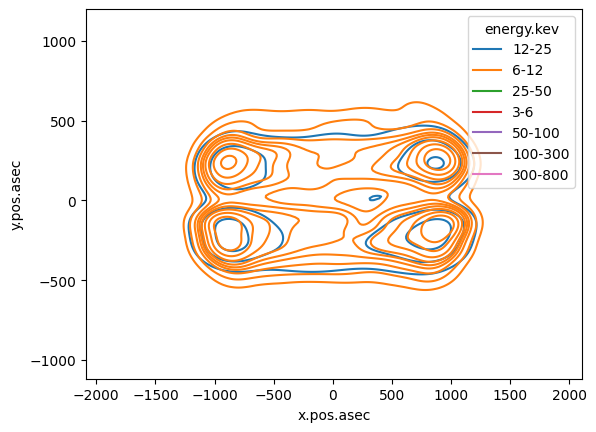

In [29]:
sns.kdeplot(data=dff,x='x.pos.asec',y='y.pos.asec',hue='energy.kev')